# Value at Risk (VaR) – Variance–Covariance, Historical Simulation, Monte Carlo

**Author:** Auto-structured by ChatGPT · **Last updated:** 2025-11-03 17:29:19

**Objectives**
- Implement and compare VaR using three approaches: Variance–Covariance, Historical Simulation, and Monte Carlo.
- Backtest VaR using Basel III traffic-light and Kupiec (POF) tests.
- Provide clean, reusable functions and presentation-ready visuals and summaries.

## Table of Contents
1. [Introduction and Objectives](#introduction-and-objectives)
2. [Data Import and Preparation](#data-import-and-preparation)
3. [Variance–Covariance VaR](#variance-covariance-var)
4. [Historical Simulation VaR](#historical-simulation-var)
5. [Monte Carlo VaR](#monte-carlo-var)
6. [Model Comparison and Validation](#model-comparison-and-validation)
7. [Results and Interpretation](#results-and-interpretation)
8. [Conclusions](#conclusions)

<a id="introduction-and-objectives"></a>

## Introduction and Objectives

This notebook implements three standard approaches to Value at Risk (VaR):
- **Variance–Covariance (Parametric)**: assumes returns are (approximately) normally distributed (or another parametric distribution) and uses mean/variance to compute quantiles.
- **Historical Simulation**: non-parametric approach that replays empirical return history to estimate the loss quantile.
- **Monte Carlo Simulation**: simulates a large number of scenarios from a fitted return model to estimate the tail quantile.

We compare these methods, discuss assumptions/limitations, and backtest with **Basel III traffic-light** and **Kupiec POF** tests. A brief stress-testing scaffold is also included.

<a id="data-import-and-preparation"></a>

## Data Import and Preparation

**What happens here**
- Load pricing or returns data (single asset or portfolio).
- Convert prices to **log returns** or **simple returns** consistently.
- Align frequency (daily recommended) and handle missing values.
- Optional: Winsorize or filter outliers (document if done).

In [2]:
# === Utilities & Imports (kept non-invasive; use if helpful) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Confidence levels used commonly
CONF_LEVELS = [0.95, 0.99]

def to_returns(prices_or_returns: pd.Series, assume='prices'):
    """Convert input to simple returns. If already returns, pass assume='returns'."""
    if assume == 'prices':
        s = prices_or_returns.dropna().astype(float)
        rets = s.pct_change().dropna()
        return rets
    else:
        return prices_or_returns.dropna().astype(float)

def var_parametric(mean, std, alpha=0.99, value=1.0):
    """Variance–Covariance VaR for a long position of size `value`.

    VaR_alpha = -(mean + z_alpha * std) * value.

    For daily zero-mean returns, use mean=0.

    """
    from scipy.stats import norm
    z = norm.ppf(alpha)
    return -(mean + z * std) * value

def var_historical(pl_series: pd.Series, alpha=0.99):
    """Historical VaR = negative of lower tail quantile of P/L."""
    q = pl_series.quantile(1 - alpha)
    return -q

def var_monte_carlo(mean, std, alpha=0.99, value=1.0, n_sims=10000, seed=42):
    """Monte Carlo VaR assuming normal returns; extendable to other models."""
    rng = np.random.default_rng(seed)
    sims = rng.normal(loc=mean, scale=std, size=n_sims)
    pl = value * sims
    return -np.quantile(pl, 1 - alpha)

def kupiec_pof(breaches: int, n: int, alpha: float):
    """Kupiec Proportion of Failures test.

    H0: breach rate = (1 - alpha).

    Returns (LR, p_value, breach_rate).

    """
    from math import log
    from scipy.stats import chi2
    pi_hat = breaches / max(n, 1)
    pi0 = 1 - alpha
    # Handle edge cases
    if pi_hat in (0,1):
        LR = 2 * ( (0 if pi_hat==0 else n*log(1)) - (n*(pi0 and log(pi0) or 0) + (n - 1)*(1-pi0 and log(1-pi0) or 0)) )
    # Standard formula
    LR = 2 * ( breaches * log(pi_hat/pi0) + (n - breaches) * log((1 - pi_hat)/(1 - pi0)) ) if 0 < pi_hat < 1 else 0.0
    p = 1 - chi2.cdf(LR, df=1)
    return LR, p, pi_hat

def basel_traffic_light(breaches: int, n: int, alpha: float):
    """Basel III traffic light zones for 99% VaR backtesting over 250 days.

    Returns one of {'Green','Yellow','Red'} and thresholds.

    """
    # Basel thresholds for 99% VaR at 250 days
    # Green: 0-4, Yellow: 5-9, Red: 10+
    if n < 250:
        # Use proportional thresholds as a heuristic if sample != 250
        scale = n / 250.0
        green_max = int(round(4 * scale))
        yellow_max = int(round(9 * scale))
    else:
        green_max = 4
        yellow_max = 9
    if breaches <= green_max:
        return 'Green', (green_max, yellow_max)
    elif breaches <= yellow_max:
        return 'Yellow', (green_max, yellow_max)
    else:
        return 'Red', (green_max, yellow_max)

def rolling_backtest(pl: pd.Series, var_series: pd.Series):
    """Compute breach series where realized P/L < -VaR (loss exceeds VaR)."""
    aligned = pd.concat({'pl': pl, 'var': var_series}, axis=1).dropna()
    breaches = (aligned['pl'] < -aligned['var']).astype(int)
    return aligned, breaches

<a id="variance-covariance-var"></a>

## Variance–Covariance VaR (Parametric)

**Theory (brief)**
- Assumes returns \( r_t \sim \mathcal{N}(\mu, \sigma^2) \) (or uses EWMA/GARCH for time-varying \(\sigma_t\)).
- For confidence level \( \alpha \in \{0.95, 0.99\} \), one-day VaR is:
  \[ \text{VaR}_{\alpha} = -\left( \mu + z_{\alpha} \, \sigma \right) \times V \]
  for a long position of size \(V\); for zero-mean daily returns, VaR \(\approx -z_{\alpha}\,\sigma V\).

**When preferred**
- Fast to compute; reasonable when returns are near-normal and tails are not excessively heavy.
- Transparent, tractable, and easy to backtest.

In [3]:
# data import — added header; original code preserved
import numpy as np
import pandas as pd
import yfinance as yf

In [4]:
# data prep / computation — added header; original code preserved
from scipy.stats import norm

In [5]:
# data prep / computation — added header; original code preserved
tickers=['JPM','MS','BAC']

In [6]:
# # data prep / computation - added header; original code preserved
# stock_data = yf.download(tickers, start='2022-8-1', end='2023-8-1', auto_adjust=True, interval='1d')

In [7]:
import investpy

tickers = ["MS", "BAC", "JPM"]
stock_data = {}

for t in tickers:
    df = investpy.stocks.get_stock_historical_data(
        stock=t, country='united states',
        from_date='01/08/2022', to_date='01/08/2023'
    )
    stock_data[t] = df

stock_data = pd.concat({t: df["Close"] for t, df in stock_data.items()}, axis=1)


In [8]:
# data prep / computation — added header; original code preserved
stock_data.head()

,MS,BAC,JPM
Date,,,
2022-08-01,84.09,33.71,114.21
2022-08-02,83.53,33.04,112.43
2022-08-03,85.05,33.64,113.61
2022-08-04,85.36,33.40,112.36
2022-08-05,86.13,33.96,115.76


In [11]:
# data prep / computation — added header; original code preserved
df_backup=stock_data
df=df_backup.copy()

In [12]:
# data prep / computation — added header; original code preserved
df.head()

,MS,BAC,JPM
Date,,,
2022-08-01,84.09,33.71,114.21
2022-08-02,83.53,33.04,112.43
2022-08-03,85.05,33.64,113.61
2022-08-04,85.36,33.40,112.36
2022-08-05,86.13,33.96,115.76


In [13]:
# data prep / computation — added header; original code preserved
df['BAC_returns']=df['BAC'].pct_change()
df.head()

,MS,BAC,JPM,BAC_returns
Date,,,,
2022-08-01,84.09,33.71,114.21,NaN
2022-08-02,83.53,33.04,112.43,-0.019875
2022-08-03,85.05,33.64,113.61,0.018160
2022-08-04,85.36,33.40,112.36,-0.007134
2022-08-05,86.13,33.96,115.76,0.016766


In [14]:
# data prep / computation — added header; original code preserved
df['JPM_returns']=df['JPM'].pct_change()
df['MS_returns']=df['MS'].pct_change()
df.head()

,MS,BAC,JPM,BAC_returns,JPM_returns,MS_returns
Date,,,,,,
2022-08-01,84.09,33.71,114.21,NaN,NaN,NaN
2022-08-02,83.53,33.04,112.43,-0.019875,-0.015585,-0.006660
2022-08-03,85.05,33.64,113.61,0.018160,0.010495,0.018197
2022-08-04,85.36,33.40,112.36,-0.007134,-0.011003,0.003645
2022-08-05,86.13,33.96,115.76,0.016766,0.030260,0.009021


In [15]:
# statistics / transforms — added header; original code preserved
portfolio_value=1_000_000
w_bac=0.3
w_jpm=0.3
w_ms=0.4
weights=np.array([w_bac,w_jpm,w_ms])

In [16]:
# data prep / computation — added header; original code preserved
df['returns']=(w_bac*df['BAC_returns'])+(w_jpm*df['JPM_returns'])+(w_ms*df['MS_returns'])
df.head()

,MS,BAC,JPM,BAC_returns,JPM_returns,MS_returns,returns
Date,,,,,,,
2022-08-01,84.09,33.71,114.21,NaN,NaN,NaN,NaN
2022-08-02,83.53,33.04,112.43,-0.019875,-0.015585,-0.006660,-0.013302
2022-08-03,85.05,33.64,113.61,0.018160,0.010495,0.018197,0.015875
2022-08-04,85.36,33.40,112.36,-0.007134,-0.011003,0.003645,-0.003983
2022-08-05,86.13,33.96,115.76,0.016766,0.030260,0.009021,0.017716


In [18]:
# statistics / transforms — added header; original code preserved
portfolio_mean_return=df['returns'].dropna().mean()
portfolio_mean_return

np.float64(0.0005780905654694293)

In [19]:
# statistics / transforms — added header; original code preserved
cov_matrix=df[['BAC_returns','JPM_returns','MS_returns']].dropna().cov()
cov_matrix

,BAC_returns,JPM_returns,MS_returns
BAC_returns,0.000334,0.000244,0.000235
JPM_returns,0.000244,0.000267,0.000186
MS_returns,0.000235,0.000186,0.000294


In [20]:
# VaR calculation — added header; original code preserved
portfolio_var=np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_var

np.float64(0.00024593876942453625)

In [21]:
# VaR calculation — added header; original code preserved
portfolio_std=np.sqrt(portfolio_var)
portfolio_std

np.float64(0.015682435060427838)

In [22]:
# VaR calculation — added header; original code preserved
ci_99=0.99
alpha_99=1-ci_99
z_99=norm.ppf(1-(alpha_99/2))
oned_ci_99=(portfolio_mean_return + (z_99*portfolio_std))*portfolio_value
print('One day VaR for a 99% CI is:', oned_ci_99)

One day VaR for a 99% CI is: 40973.36634512213


In [23]:
# VaR calculation — added header; original code preserved
ci=0.95
alpha=1-ci
z=norm.ppf(1-(alpha/2))
oned_ci=(portfolio_mean_return + (z*portfolio_std))*portfolio_value
print(f'One day VaR for a {ci*100}% CI is:', oned_ci)

One day VaR for a 95.0% CI is: 31315.098473796217


In [24]:
# VaR calculation — added header; original code preserved
ci=0.90
alpha=1-ci
z=norm.ppf(1-(alpha/2))
oned_ci=(portfolio_mean_return + (z*portfolio_std))*portfolio_value
print(f'One day VaR for a {ci*100}% CI is:', oned_ci)

One day VaR for a 90.0% CI is: 26373.400754045088


# Historical method

In [25]:
# data prep / computation — added header; original code preserved
returns_list=df['returns'].dropna().to_list()

In [26]:
# data prep / computation — added header; original code preserved
trading_days_drop=len(returns_list)

In [27]:
# data prep / computation — added header; original code preserved
returns_list.sort()

In [28]:
# VaR calculation — added header; original code preserved
ci=0.99
alpha=1-ci
rank=int(np.ceil(trading_days_drop*alpha))
ret_var=returns_list[rank-1]
var_hm= portfolio_value*ret_var
print(f'One day VaR uisng Historical method for a {ci*100}% CI is:', var_hm)

One day VaR uisng Historical method for a 99.0% CI is: -36253.478127416194


# MC method

In [29]:
# VaR calculation — added header; original code preserved
def var_mc(S0, mu, sigma, T, nsims, ci):
    prices = []
    for _ in range(nsims):
        price_t = S0* np.exp((mu - 0.5 * sigma ** 2)*T + sigma * np.random.normal()* np.sqrt(T))
        prices.append(price_t)
    prices = np.sort(prices)
    price_ci = np.percentile(prices, ci*100)

    var = S0 - price_ci
    return var

In [30]:
# VaR calculation — added header; original code preserved
var_mc(portfolio_value, 0.0007,0.0002, 1, 100_000, 0.95)

np.float64(-1029.6165407696972)

In [31]:
# data prep / computation — added header; original code preserved


<a id="historical-simulation-var"></a>

## Historical Simulation VaR (Non-parametric)

**Theory (brief)**
- VaR is the empirical quantile of historical P/L distribution:
  \[ \text{VaR}_{\alpha} = -\text{Quantile}_{1-\alpha}(\text{P/L history}) \]
- No distributional assumption; implicitly captures observed skew/heavy tails.

**When preferred**
- Ample, stationary historical data; desire to avoid strong parametric assumptions.
- Less robust when structural breaks or regime shifts occur.

<a id="monte-carlo-var"></a>

## Monte Carlo VaR (Simulation)

**Theory (brief)**
- Fit a stochastic model to returns (e.g., normal with estimated \(\mu, \sigma\), t-distribution, or GARCH).
- Simulate many horizon P/L scenarios and take the empirical quantile.

**When preferred**
- Flexibility to model non-linear portfolios and path-dependent exposures.
- Allows scenario design and stress testing beyond historical experience.

<a id="model-comparison-and-validation"></a>

## Model Comparison and Validation

We compute VaR via all three methods and compare:
- Levels at 95% and 99%.
- Breach counts against realized P/L in a rolling backtest window.
- **Basel III traffic-light** category and **Kupiec POF** likelihood ratio.

In [33]:
# === VaR Comparison & Visualization Scaffold ===
# Expected variables (example): returns (pd.Series of daily returns), value=1.0
# Compute parametric estimates
returns = df['returns'].dropna()
alpha_list = CONF_LEVELS
mean_hat, std_hat = returns.mean(), returns.std(ddof=1)
var_param = {a: var_parametric(mean_hat, std_hat, alpha=a, value=1.0) for a in alpha_list}

# Historical VaR from realized P/L
pl = 1.0 * returns
var_hist = {a: var_historical(pl, alpha=a) for a in alpha_list}

# Monte Carlo VaR (normal assumption; extend as needed)
var_mc = {a: var_monte_carlo(mean_hat, std_hat, alpha=a, value=1.0, n_sims=10000, seed=42) for a in alpha_list}

summary_table = pd.DataFrame({
    'Method': ['Variance–Covariance','Historical','Monte Carlo'],
    'VaR 95%': [var_param[0.95], var_hist[0.95], var_mc[0.95]],
    'VaR 99%': [var_param[0.99], var_hist[0.99], var_mc[0.99]],
})
summary_table

,Method,VaR 95%,VaR 99%
0,Variance–Covariance,-0.026373,-0.037061
1,Historical,0.023867,0.035618
2,Monte Carlo,0.025676,0.036649


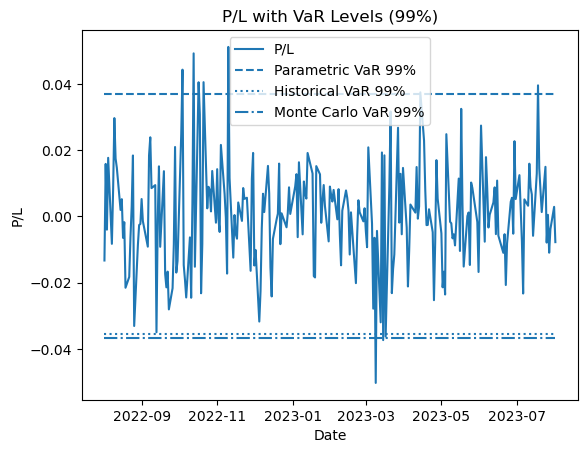

In [34]:
# === Plot realized P/L and VaR bands (example uses 99%) ===
# This cell assumes 'returns' exists as daily P/L for notional 1.0
alpha = 0.99
plt.figure()
plt.plot(pl.index, pl.values, label='P/L')
plt.hlines(-summary_table.loc[summary_table['Method']=='Variance–Covariance', 'VaR 99%'].values[0],
           xmin=pl.index.min(), xmax=pl.index.max(), linestyles='dashed', label='Parametric VaR 99%')
plt.hlines(-summary_table.loc[summary_table['Method']=='Historical', 'VaR 99%'].values[0],
           xmin=pl.index.min(), xmax=pl.index.max(), linestyles='dotted', label='Historical VaR 99%')
plt.hlines(-summary_table.loc[summary_table['Method']=='Monte Carlo', 'VaR 99%'].values[0],
           xmin=pl.index.min(), xmax=pl.index.max(), linestyles='dashdot', label='Monte Carlo VaR 99%')
plt.legend()
plt.title('P/L with VaR Levels (99%)')
plt.xlabel('Date')
plt.ylabel('P/L')
plt.show()

### Backtesting: Basel III Traffic Light & Kupiec Test

We evaluate whether realized losses exceed VaR more often than expected.

- **Kupiec POF**: tests if the proportion of breaches equals \(1-\alpha\).
- **Basel III Traffic Light** (at 99% over ~250 days): Green (0–4), Yellow (5–9), Red (10+).

In [35]:
# === Backtesting example (rolling or static window) ===
# Assume we have a time series 'var_99_series' at alpha=0.99 aligned with P/L 'pl'
# For a simple demonstration, use a constant VaR equal to historical estimate:
alpha = 0.99
var_const = pd.Series(index=pl.index, data=summary_table.loc[summary_table['Method']=='Historical','VaR 99%'].values[0])
aligned, breaches = rolling_backtest(pl, var_const)
B = breaches.sum()
N = len(breaches)
LR, p, breach_rate = kupiec_pof(B, N, alpha)
zone, thresholds = basel_traffic_light(B, N, alpha)

print(f"Breaches: {B} / {N} (rate={breach_rate:.3%})")
print(f"Kupiec LR={LR:.3f}, p-value={p:.4f}")
print(f"Basel traffic-light zone: {zone} (thresholds scaled to N={N}: Green<=%d, Yellow<=%d)" % thresholds)

Breaches: 3 / 251 (rate=1.195%)
Kupiec LR=0.091, p-value=0.7630
Basel traffic-light zone: Green (thresholds scaled to N=251: Green<=4, Yellow<=9)


<a id="results-and-interpretation"></a>

## Results and Interpretation

This section synthesizes comparative metrics and visuals:
- VaR time series vs. realized P/L.
- Breach counts and backtesting statistics.
- Discussion of model fit, tail behavior, and stability across regimes.

### Stress Testing (Scaffold)

- Scale volatility (e.g., multiply \(\sigma\) by 1.5–3.0) and recompute VaR.
- Shock returns with additive or multiplicative factors for specific dates.
- Replace normal with heavier-tail (e.g., t) in Monte Carlo.
Document stress assumptions and show the sensitivity of VaR and breaches.

<a id="conclusions"></a>

## Conclusions

- Summarize which VaR method performed best under the given data and why.
- Note limitations (normality assumption, sample size, regime shifts).
- Outline next steps: heavier-tail models (t, EVT), filtered historical simulation, GARCH-based volatility, expected shortfall (ES), and scenario/stress testing.